# Final Project: Smart Folders for Work Email

April 2018

Group Members: Danny, Grace, Rutika, Adarsh

In this notebook we explore a data set of emails provided in a [Kaggle data set](https://www.kaggle.com/wcukierski/enron-email-dataset) by Enron Corp. This data set provides a set of about 500K employee emails, which include several fields including a `folder` field.

The goal is to build machine learning models that help users organize their email for more efficient processing. More detail on the motivation and goals of this analysis [can be found here](https://docs.google.com/presentation/d/1r-nWFn-2o1xrc-Ohz-S-30QQYIkEBCyuGOw891gefMY/edit?usp=sharing). We'll split the analysis into two parts:

1. In the first section, we'll attempt to use existing folders created by users. We'll train a model for each user that will accept new emails and predict the folder which the user would have sorted it to. This is a supervised learning problem, where the label for each data point is the folder to which it belongs.
2. In the second section, we'll instead try to organize folders in a company-wide fashion. This will be an unsupervised problem, where we attempt to organize folders into similar folders without a labeled data set.

In [10]:
# load libraries
%matplotlib inline

import re
import pandas
import gensim
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from gensim import corpora, models
from __future__ import division

# Load Data

The data from the kaggle data set is provided as a CSV file. However, the file is poorly schematized, requiring file specific logic to parse out properties of the data set correctly.

In [2]:
enron_dataset_file_name = '../../source-data/emails.csv'

with open(enron_dataset_file_name, 'rb') as f_in:
    raw_email_info = f_in.read()

    # Extract features we may potentially want to use (minus email body)
    dates = re.findall(r'\nDate: (.*)', raw_email_info)
    sender_addresses = re.findall(r'\nFrom: (.*)', raw_email_info)
    recipients = re.findall(r'\nTo: (.*)', raw_email_info)
    subjects = re.findall(r'\nSubject: (.*)', raw_email_info)
    sender_names = re.findall(r'\nX-From: (.*)', raw_email_info)
    recipient_names = re.findall(r'\nX-To: ([ A-Za-z]*)', raw_email_info)
    ccs = re.findall(r'\nX-cc: (.*)', raw_email_info)
    bccs = re.findall(r'\nX-bcc: (.*)', raw_email_info)
    filename = re.findall(r'\nX-FileName: (.*)', raw_email_info)
    folders = re.findall(r'"[a-zA-z-]*/(.*)/.*,"Message-ID.*>', raw_email_info)

    # Strip out all features to extract email body
    raw_email_info = re.sub(r'\nDate: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nFrom: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nTo: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nSubject: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-From: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-To: ([ A-Za-z]*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-cc: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-bcc: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-Folder: (.*)', '', raw_email_info)

    raw_email_info = re.sub(r'"file","message"', '', raw_email_info)
    raw_email_info = re.sub(r'\nMime-Version: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nContent-Type: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nContent-Transfer-Encoding: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-Origin: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-FileName: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'".*Message-ID.*>', 'file_name_and_message_id', raw_email_info)

    bodies = raw_email_info.split('file_name_and_message_id')[1:]

    email_features = zip(dates,
                         sender_addresses,
                         recipients,
                         subjects,
                         sender_names,
                         recipient_names,
                         ccs,
                         bccs,
                         folders,
                         filename,
                         bodies)

    # Stick features into a dataframe to make it easy to query and filter out data
    email_data = pandas.DataFrame(email_features, columns=['date',
                                                       'sender_address',
                                                       'recipient',
                                                       'subject',
                                                       'sender_name',
                                                       'recipient_name',
                                                       'cc',
                                                       'bcc',
                                                       'folder',
                                                       'filename',
                                                       'body'])
    
    print 'Number of emails in the dataset: {}'.format(email_data.shape[0])

Number of emails in the dataset: 513954


# Text Data Cleansing

Next, we apply some simple text cleaning to the data set. This includes removing links, stop words, and standardized casing.

In [4]:
def clean_body_text(body):
    tokenizer = RegexpTokenizer(r'\w+')
    # Create English stop words list
    en_stop_words = get_stop_words('en')
    p_stemmer = PorterStemmer()
    # Remove all numbers, remove structural words, and remove stop words
    def filter_body(x):
        if (not (x.isdigit() or x[0] == '-' and x[1:].isdigit())) and len(x) > 1 and 'http' not in x and x not in "_" and x not in en_stop_words:
            return True

    # Clean and tokenize document string
    tokens = filter(filter_body, tokenizer.tokenize(body))
    # Lowercase all text
    tokens = [x.lower() for x in tokens]
    # Stem tokens
    return [p_stemmer.stem(unicode(i, errors='ignore')) for i in tokens]

email_data['body'] = email_data['body'].apply(clean_body_text)

# Examine email data after cleansing bodies
email_data.head()

/Users/adarshramakrishnan/Documents/python_playground/leetcode_stuff/venv/lib/python2.7/site-packages/ipykernel_launcher.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  
/Users/adarshramakrishnan/Documents/python_playground/leetcode_stuff/venv/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,sender_address,recipient,subject,sender_name,recipient_name,cc,bcc,folder,filename,body
1230,"Tue, 24 Oct 2000 05:16:00 -0700 (PDT)",phillip.allen@enron.com,"Cheryl Wilchynski/HR/Corp/Enron@ENRON, Cindy R...","""""Save the Date"""" - Associate / Analyst Program",Outlook-Migration-Team </O=ENRON/OU=NA/CN=RECI...,,,,contacts,pallen (Non-Privileged).pst,"[loan, servic, jessica, weeber, jweeber, spban..."
1231,"Mon, 23 Oct 2000 08:55:00 -0700 (PDT)",phillip.allen@enron.com,"phillip.allen@enron.com, robina.barker-bennett...",,Outlook-Migration-Team </O=ENRON/OU=NA/CN=RECI...,,,,contacts,pallen (Non-Privileged).pst,"[exit, mccollough]"
3026,"Wed, 6 Dec 2000 04:43:00 -0800 (PST)",phillip.allen@enron.com,richard.morgan@austinenergy.com,RE:,bobregon@bga.com,list,,,straw,pallen.nsf,"[hi, all, we, look, wheat, farmer, near, austi..."
3027,"Mon, 25 Sep 2000 05:47:00 -0700 (PDT)",phillip.allen@enron.com,gthorse@keyad.com,RE:,rob_tom@freenet.carleton.ca (Robert W. Tom),CALXA,strawbale@crest.org,,straw,pallen.nsf,"[cc, strawbal, crest, org, bcc, strawbal, cres..."
3028,"Fri, 22 Sep 2000 00:06:00 -0700 (PDT)",phillip.allen@enron.com,monica.l.brown@accenture.com,,CALXA@aol.com,strawbale,moore.john.e@worldnet.att.net (John E. Moore),,straw,pallen.nsf,"[cc, moor, john, worldnet, att, net, bcc, moor..."


# 1. Supervised Learning: Per-User Auto-Sorting

We will now use supervised learning techniques to predict which folders users are most likely to sort their emails into.

## Feature Engineering

### Filter out system folders that are not relevent for sort predictions

While the original data set contained 500K emails, most users do not sort their emails into custom user defined folders. Most users simply leave emails in system-defined folders. For this section, we'll omit any emails in these folders.

In [3]:
# Remove folders that are most likely computer generated
filtered_email_data = email_data[
    (email_data.folder != '_sent_mail') &
    (email_data.folder != 'all_documents') &
    (email_data.folder != 'deleted_items') &
    (email_data.folder != 'inbox') &
    (email_data.folder != 'discussion_threads') &
    (email_data.folder != 'notes_inbox') &
    (email_data.folder != 'sent_items') &
    (email_data.folder != 'sent')
]

print 'Number of emails in the dataset after filtering folders: {}'.format(filtered_email_data.shape[0])

# Examine filtered email data
filtered_email_data.head()

Number of emails in the dataset after filtering folders: 73051


,date,sender_address,recipient,subject,sender_name,recipient_name,cc,bcc,folder,filename,body
1230,"Tue, 24 Oct 2000 05:16:00 -0700 (PDT)",phillip.allen@enron.com,"Cheryl Wilchynski/HR/Corp/Enron@ENRON, Cindy R...","""""Save the Date"""" - Associate / Analyst Program",Outlook-Migration-Team </O=ENRON/OU=NA/CN=RECI...,,,,contacts,pallen (Non-Privileged).pst,\n\nloan servicing-jessica weeber 800-393-5626...
1231,"Mon, 23 Oct 2000 08:55:00 -0700 (PDT)",phillip.allen@enron.com,"phillip.allen@enron.com, robina.barker-bennett...",,Outlook-Migration-Team </O=ENRON/OU=NA/CN=RECI...,,,,contacts,pallen (Non-Privileged).pst,"\n\nexit mccollough off 410""\n"
3026,"Wed, 6 Dec 2000 04:43:00 -0800 (PST)",phillip.allen@enron.com,richard.morgan@austinenergy.com,RE:,bobregon@bga.com,list,,,straw,pallen.nsf,\n\nHi All\n\nWe are looking for a wheat farme...
3027,"Mon, 25 Sep 2000 05:47:00 -0700 (PDT)",phillip.allen@enron.com,gthorse@keyad.com,RE:,rob_tom@freenet.carleton.ca (Robert W. Tom),CALXA,strawbale@crest.org,,straw,pallen.nsf,\nCc: strawbale@crest.org\nBcc: strawbale@cres...
3028,"Fri, 22 Sep 2000 00:06:00 -0700 (PDT)",phillip.allen@enron.com,monica.l.brown@accenture.com,,CALXA@aol.com,strawbale,moore.john.e@worldnet.att.net (John E. Moore),,straw,pallen.nsf,\nCc: moore.john.e@worldnet.att.net\nBcc: moor...


### Drop unusable rows, create a new people column

Next, we'll construct the features to be used in our models. One such feature is the people included in the email. Rather than construct individual features for each of the To, From, CC, and BCC lines, we'll model a single feature that includes all people in the email.

In [6]:
# Drop rows without subject or body
filtered_email_data = filtered_email_data.dropna(subset=['subject', 'body'])

# Create a new "people" column that combines CC, BCC, Sender Address, and Recipient
filtered_email_data['cc'].fillna('', inplace=True)
filtered_email_data['bcc'].fillna('', inplace=True)
filtered_email_data['sender_address'].fillna('', inplace=True)
filtered_email_data['recipient'].fillna('', inplace=True)
filtered_email_data['people'] = filtered_email_data['sender_address'] + ',' + filtered_email_data['cc'] + ',' + filtered_email_data['bcc'] + ',' + filtered_email_data['recipient']

### Segment data by recipient, to train one model per-user

Before creating our models, we now need to segment the data set into individual data sets (one per user). This will allow us to construct one model per user in the Enron data set.

In [7]:
# Create a new "user" column by extracting data from the filename feature
def extract_user(text):
    m = re.search(r'^([^\. ]*)[\. ]', text)
    if m:
        return m.group(1)
    return ''

filtered_email_data['user'] = filtered_email_data['filename'].apply(extract_user)

# Group dataset by user
user_groups = filtered_email_data.groupby('user')
users = user_groups.groups.keys()

print 'Number of users in the data set: ' + str(len(users))

Number of users in the data set: 267


### Run per-user logistic regression, record accuracy

Our first model will be a logistic regression model. For each user, we transform the subject of the email and the people in the email into a vectorized feature matrix. This allows each user to have their own custom vocabulary, specific to their mailbox. For each user, we record the accuracy of the Logistic Regression classifier for further analysis.



Total number of users analyzed: 97
Average accuracy for Logistic Regression: 0.51063628577788


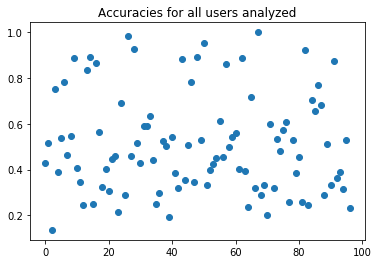

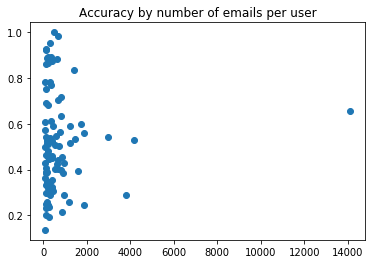

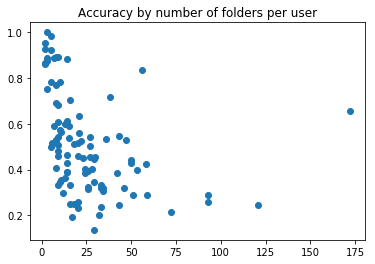

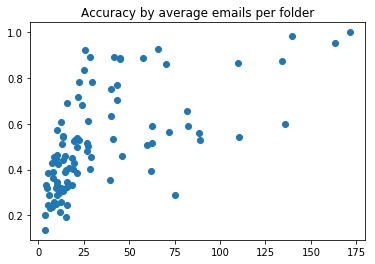

In [12]:
def people_tokenizer(s):
    people = s.split(',')
    return filter(None, people)

min_email_threshold = 100

num_users = 0
accuracies = []
num_folders = []
num_emails = []
for user, emails in user_groups:
    # Skip over any users with too few emails to analyze (less than 100)
    if len(emails) < min_email_threshold:
        continue
        
    # Perform bag of words vectorization on Subject
    sub_vect = CountVectorizer(stop_words='english', lowercase=True)
    counts = sub_vect.fit_transform(emails['subject'])

    # Convert Subject from booleans to tf-idf values
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(counts)

    # Convert people column into email address counts
    people_vec = CountVectorizer(lowercase=True, tokenizer=people_tokenizer)
    people_counts = people_vec.fit_transform(emails['people'])

    # Merge people counts with subject tf-idf
    feature_matrix = scipy.sparse.hstack([people_counts, tfidf])
    
    # Split into training & test sets
    labels_train, labels_test, features_train, features_test = train_test_split(
        emails['folder'], feature_matrix, test_size=0.20, random_state=42)

    # Run Multiclass Logistic Regression
    lr = LogisticRegression(C=0.1)
    try:
        lr.fit(features_train, labels_train)
    
    # If a user only has emails in a single folder, a ValueError is raised
    # This solver needs samples of at least 2 classes in the data, but the data contains only one class
    except ValueError:
        continue
    test_predict_lr = lr.predict(features_test)
    score_lr = accuracy_score(y_true=labels_test, y_pred=test_predict_lr)
    
    num_users += 1
    accuracies.append(score_lr)
    num_emails.append(len(emails))
    num_folders.append(len(lr.classes_))
    
print '\n\nTotal number of users analyzed: ' + str(num_users)
print 'Average accuracy for Logistic Regression: ' + str(np.mean(accuracies))

plt.title('Accuracies for all users analyzed')
plt.plot(accuracies, 'o')
plt.show()

plt.title('Accuracy by number of emails per user')
plt.plot(num_emails, accuracies, 'o')
plt.show()

plt.title('Accuracy by number of folders per user')
plt.plot(num_folders, accuracies, 'o')
plt.show()

plt.title('Accuracy by average emails per folder')
plt.plot([x/y for x, y in zip(num_emails, num_folders)], accuracies, 'o')
plt.show()

### Run per-user naive bayes, record accuracy

Next, we'll switch our model to a Naive Bayes classifier, following the same process from above, and analyzing the accuracy results.



Total number of users analyzed: 98
Average accuracy for Naive Bayes: 0.6152519127779699


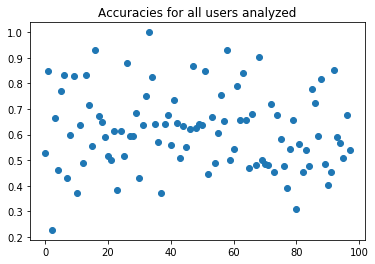

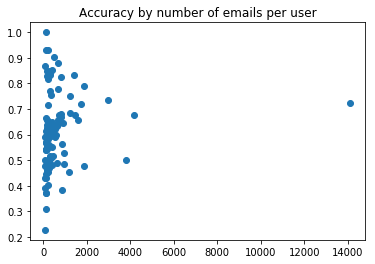

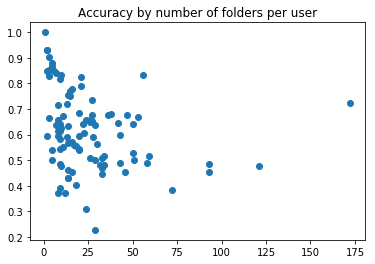

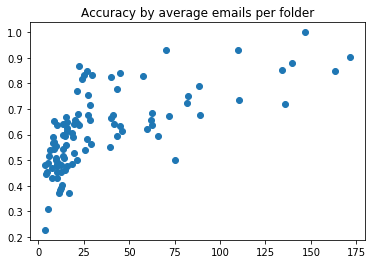

In [14]:
def people_tokenizer(s):
    people = s.split(',')
    return filter(None, people)

min_email_threshold = 100

num_users = 0
accuracies = []
num_folders = []
num_emails = []
for user, emails in user_groups:
    # Skip over any users with too few emails to analyze (less than 100)
    if len(emails) < min_email_threshold:
        continue
        
    # Perform bag of words vectorization on Subject
    sub_vect = CountVectorizer(stop_words='english', lowercase=True)
    counts = sub_vect.fit_transform(emails['subject'])

    # Convert Subject from booleans to tf-idf values
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(counts)

    # Convert people column into email address counts
    people_vec = CountVectorizer(lowercase=True, tokenizer=people_tokenizer)
    people_counts = people_vec.fit_transform(emails['people'])

    # Merge people counts with subject tf-idf
    feature_matrix = scipy.sparse.hstack([people_counts, tfidf])
    
    # Split into training & test sets
    labels_train, labels_test, features_train, features_test = train_test_split(
        emails['folder'], feature_matrix, test_size=0.20, random_state=42)
    
    # Run Multinomial Naive Bayes
    mnb = MultinomialNB(alpha=0.1)
    mnb.fit(features_train, labels_train)
    test_predict_mnb = mnb.predict(features_test)
    score_mnb = accuracy_score(labels_test, test_predict_mnb)
        
    num_users += 1
    accuracies.append(score_mnb)
    num_emails.append(len(emails))
    num_folders.append(len(mnb.classes_))
    
print '\n\nTotal number of users analyzed: ' + str(num_users)
print 'Average accuracy for Naive Bayes: ' + str(np.mean(accuracies))

plt.title('Accuracies for all users analyzed')
plt.plot(accuracies, 'o')
plt.show()

plt.title('Accuracy by number of emails per user')
plt.plot(num_emails, accuracies, 'o')
plt.show()

plt.title('Accuracy by number of folders per user')
plt.plot(num_folders, accuracies, 'o')
plt.show()

plt.title('Accuracy by average emails per folder')
plt.plot([x/y for x, y in zip(num_emails, num_folders)], accuracies, 'o')
plt.show()

### Run per-user models, compare accuracies

Finally, we'll try both of the models from the above section, choosing whichever model (Logistic Regression vs. Naive Bayes) works better for that particular user. The purpose of this section is to examine which models work better for certain types of users, and with which frequency a certain model is effective.



Total number of users analyzed: 97
Average accuracy: 0.6398781477778984


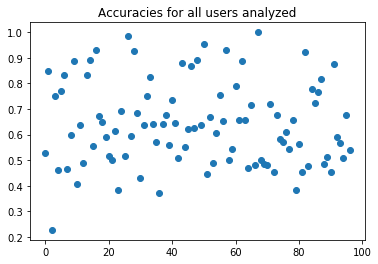

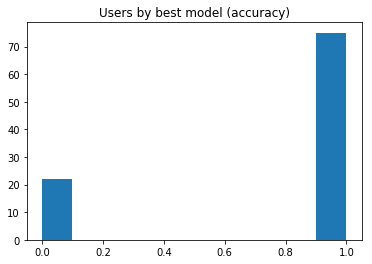

In [15]:
def people_tokenizer(s):
    people = s.split(',')
    return filter(None, people)

min_email_threshold = 100

num_users = 0
accuracies = []
num_folders = []
num_emails = []
best_models = []
for user, emails in user_groups:
    
    # Skip over any users with too few emails to analyze (less than 100)
    if len(emails) < min_email_threshold:
        continue
        
    # Perform bag of words vectorization on Subject
    sub_vect = CountVectorizer(stop_words='english', lowercase=True)
    counts = sub_vect.fit_transform(emails['subject'])

    # Convert Subject from booleans to tf-idf values
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(counts)

    # Convert people column into email address counts
    people_vec = CountVectorizer(lowercase=True, tokenizer=people_tokenizer)
    people_counts = people_vec.fit_transform(emails['people'])

    # Merge people counts with subject tf-idf
    feature_matrix = scipy.sparse.hstack([people_counts, tfidf])
    
    # Split into training & test sets
    labels_train, labels_test, features_train, features_test = train_test_split(
        emails['folder'], feature_matrix, test_size=0.20, random_state=42)

    # Run Multiclass Logistic Regression
    lr = LogisticRegression(C=0.1)
    try:
        lr.fit(features_train, labels_train)
    
    # If a user only has emails in a single folder, a ValueError is raised
    # This solver needs samples of at least 2 classes in the data, but the data contains only one class
    except ValueError:
        continue
    test_predict_lr = lr.predict(features_test)
    score_lr = accuracy_score(y_true=labels_test, y_pred=test_predict_lr)
    
    # Run Multinomial Naive Bayes
    mnb = MultinomialNB(alpha=0.1)
    mnb.fit(features_train, labels_train)
    test_predict_mnb = mnb.predict(features_test)
    score_mnb = accuracy_score(labels_test, test_predict_mnb)
    
    # Use model accuracy to determine whether to use Logistic Regression or Naive Bayes
    best_models.append((0 if score_lr > score_mnb else 1))    
        
    num_users += 1
    accuracies.append((score_lr if score_lr > score_mnb else score_mnb))
    num_emails.append(len(emails))
    num_folders.append(len(mnb.classes_))
    
print '\n\nTotal number of users analyzed: ' + str(num_users)
print 'Average accuracy: ' + str(np.mean(accuracies))

plt.title('Accuracies for all users analyzed')
plt.plot(accuracies, 'o')
plt.show()

plt.title('Users by best model (accuracy)')
plt.hist(best_models)
plt.show()

From the results of the different supervised techniques above, we can see the following:
- Using a combination of Logistic Regression and Naive Bayes to predict a user's email sorting behavior appears to result in the best performance (around 64% accuracy)
- For most users (around 75 out of 97 total analyzed), Naive Bayes is more accurate in predicting sorting behavior
- There is a definite trend showing that the more emails per folder a user has, the more accurate the model predictions are. Given this information, it is reasonable to assume that if we had users with more emails in our dataset, our accuracies should have improved

# Unsupervised Learning: Topic Modeling

In this section, we will use an Unsupervised Learning technique (Topic Modeling) to further explore our dataset. Focusing on the email bodies, we can use the topics produced by the topic model to identify patterns that emerge from the email corpus.

In [23]:
email_bodies = filtered_email_data['body'].tolist()

# Create a term dictionary from our email body corpus
dictionary = gensim.corpora.Dictionary(email_bodies)

# Convert corpus into Document Term Matrix using term dictionary
doc_term_matrix = [dictionary.doc2bow(body) for body in email_bodies]

# Run an LDA Topic Model with 10 topics
lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=10, id2word=dictionary, passes=20, minimum_probability=0)

topic_term_mapping = dict(lda_model.show_topics())

for topic_id in topic_term_mapping:
    print '\nTopic ID: {}\n Topic Terms and Probabilities: {}'.format(topic_id, topic_term_mapping[topic_id])

# For each email, assign topic with highest probability from each topic distribution
email_topics = []
for doc in doc_term_matrix:
    topic_distribution = lda_model.get_document_topics(doc)
    email_topics.append(max(topic_distribution, key=lambda item: item[1])[0])

# Find top three most frequently occurring topics from email body corpus
topic_data = pandas.DataFrame(email_topics, columns = ['topic_label'])
top_three_topic_ids = topic_data[['topic_label']].groupby(['topic_label'])['topic_label']\
    .count()\
    .reset_index(name='count')\
    .sort_values(['count'], ascending=False)\
    .head(3)['topic_label']\
    .tolist()

top_three_topics_raw = [topic_term_mapping[topic_id] for topic_id in top_three_topic_ids]
top_three_topics = []                                                                                      
for raw_topic in top_three_topics_raw:                                                                               
    top_three_topics.append(str([str(term.split('*')[1].replace('"', '')) for term in raw_topic.split(' + ')]))

print '\n\nThe top three most frequently occurring topics (seen as term groupings) taken from the email body corpus are: \n\n{}'.format('\n'.join(top_three_topics))


Topic ID: 0
 Topic Terms and Probabilities: 0.127*"ect" + 0.064*"hou" + 0.046*"ee" + 0.024*"pm" + 0.024*"cc" + 0.023*"enron_develop" + 0.019*"corp" + 0.019*"am" + 0.016*"enronxg" + 0.015*"forward"

Topic ID: 1
 Topic Terms and Probabilities: 0.014*"will" + 0.013*"pleas" + 0.012*"messag" + 0.010*"cc" + 0.010*"thank" + 0.009*"sent" + 0.008*"origin" + 0.008*"pm" + 0.008*"to" + 0.008*"subject"

Topic ID: 2
 Topic Terms and Probabilities: 0.024*"power" + 0.020*"energi" + 0.014*"the" + 0.013*"california" + 0.013*"market" + 0.012*"price" + 0.011*"electr" + 0.010*"state" + 0.009*"util" + 0.008*"ga"

Topic ID: 3
 Topic Terms and Probabilities: 0.009*"the" + 0.008*"get" + 0.008*"said" + 0.007*"one" + 0.007*"go" + 0.007*"will" + 0.007*"week" + 0.006*"time" + 0.006*"can" + 0.006*"year"

Topic ID: 4
 Topic Terms and Probabilities: 0.248*"cn" + 0.128*"recipi" + 0.123*"na" + 0.117*"ou" + 0.064*"enron" + 0.012*"notesaddr" + 0.006*"bcc" + 0.006*"pdavis1" + 0.004*"cc" + 0.002*"mvc"

Topic ID: 5
 Topic 